In [1]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")



Mounted at /content/MyDrive


In [2]:
# @title Initialize Config

import torch
import numpy
class Config:
    def __init__(self, **kwargs):
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection_v3/all_subjects_data.h5',
    dataset_root='/content/datasets',
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1','ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
)

#set seeds
torch.manual_seed(config.seed)
numpy.random.seed(config.seed)


In [3]:
class DataSharder:
    def __init__(self, config, split):
        self.config = config
        self.h5_file_path = config.data_folder_name  # Path to the HDF5 file
        self.split = split

    def load_data(self, subjects, window_length, window_overlap, dataset_name):
        print(f"Processing subjects: {subjects} with window length: {window_length}, overlap: {window_overlap}")

        self.window_length = window_length
        self.window_overlap = window_overlap

        # Process the data from the HDF5 file
        self._process_and_save_patients_h5(subjects, dataset_name)

    def _process_and_save_patients_h5(self, subjects, dataset_name):
        # Open the HDF5 file
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            dataset_folder = os.path.join(self.config.dataset_root, dataset_name, self.split).replace("subject", "").replace("__", "_")
            print("Dataset folder:", dataset_folder)

            if os.path.exists(dataset_folder):
                print("Dataset Exists, Skipping...")
                return

            os.makedirs(dataset_folder, exist_ok=True)
            print("Dataset folder created: ", dataset_folder)

            for subject_id in tqdm(subjects, desc="Processing subjects"):
                subject_key = subject_id
                if subject_key not in h5_file:
                    print(f"Subject {subject_key} not found in the HDF5 file. Skipping.")
                    continue

                subject_data = h5_file[subject_key]
                session_keys = list(subject_data.keys())  # Sessions for this subject

                for session_id in session_keys:
                    session_data_group = subject_data[session_id]

                    for sessions_speed in session_data_group.keys():
                        session_data = session_data_group[sessions_speed]

                        # Extract IMU, EMG, and Joint data as numpy arrays
                        imu_data, imu_columns = self._extract_channel_data(session_data, self.config.channels_imu_acc + self.config.channels_imu_gyr)
                        emg_data, emg_columns = self._extract_channel_data(session_data, self.config.channels_emg)
                        joint_data, joint_columns = self._extract_channel_data(session_data, self.config.channels_joints)

                        # Shard the data into windows and save each window
                        self._save_windowed_data(imu_data, emg_data, joint_data, subject_key, session_id,sessions_speed, dataset_folder, imu_columns, emg_columns, joint_columns)

    def _save_windowed_data(self, imu_data, emg_data, joint_data, subject_key, session_id, session_speed, dataset_folder, imu_columns, emg_columns, joint_columns):
        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        # Path to the CSV log file
        csv_file_path = os.path.join(dataset_folder, '..', f"{self.split}_info.csv")

        # Ensure the folder exists
        os.makedirs(dataset_folder, exist_ok=True)

        # Prepare CSV log headers (ensure the columns are 'file_name' and 'file_path')
        csv_headers = ['file_name', 'file_path']

        # Create or append to the CSV log file
        file_exists = os.path.isfile(csv_file_path)
        with open(csv_file_path, mode='a', newline='') as csv_file:
            writer = csv.writer(csv_file)

            # Write the headers only if the file is new
            if not file_exists:
                writer.writerow(csv_headers)

            # Determine the total data length based on the minimum length across the data sources
            total_data_length = min(imu_data.shape[1], emg_data.shape[1], joint_data.shape[1])

            # Adjust the starting point for windows based on total data length
            start = 2000 if total_data_length > 4000 else 0

            # Ensure that each window across imu_data, emg_data, and joint_data has the same shape before concatenation
            for i in range(start, total_data_length - window_size + 1, step_size):
                imu_window = imu_data[:, i:i + window_size]
                emg_window = emg_data[:, i:i + window_size]
                joint_window = joint_data[:, i:i + window_size]

                # Check if the window sizes are valid
                if imu_window.shape[1] == window_size and emg_window.shape[1] == window_size and joint_window.shape[1] == window_size:
                    # Convert windowed data to pandas DataFrame



                    imu_df = pd.DataFrame(imu_window.T, columns=imu_columns)
                    emg_df = pd.DataFrame(emg_window.T, columns=emg_columns)
                    joint_df = pd.DataFrame(joint_window.T, columns=joint_columns)



                    # Concatenate the data along the column axis
                    combined_df = pd.concat([imu_df, emg_df, joint_df], axis=1)

                    # Save the combined windowed data as a CSV file
                    file_name = f"{subject_key}_{session_id}_{session_speed}_win_{i}_ws{window_size}_ol{overlap}.csv"
                    file_path = os.path.join(dataset_folder, file_name)
                    combined_df.to_csv(file_path, index=False)

                    # Log the file name and path in the CSV (in the correct columns)
                    writer.writerow([file_name, file_path])
                else:
                    print(f"Skipping window {i} due to mismatched window sizes.")

    def _extract_channel_data(self, session_data, channels):
        """
        Extracts data for the given channels from the dataset (whether it's a compound dataset or simple dataset),
        and interpolates missing values (NaNs) in each channel data.
        """
        extracted_data = []
        column_names = []

        if isinstance(session_data, h5py.Dataset):
            # Check if the dataset has named fields (compound dataset)
            if session_data.dtype.names:
                # Compound dataset, use the named fields
                column_names = session_data.dtype.names
                for channel in channels:
                    if channel in column_names:
                        channel_data = session_data[channel][:]  # Access by field name
                        # Convert the data to a numeric type (float), if necessary
                        channel_data = pd.to_numeric(channel_data, errors='coerce')
                        # Interpolate NaN values
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                    else:
                        print(f"Channel {channel} not found in compound dataset.")
            else:
                # Simple dataset, use index-based access (no named fields)
                column_names = session_data.attrs.get('column_names', [])

                # Cast column_names to a list to allow 'index' lookup
                column_names = list(column_names)
                new_column_names = []

                assert len(column_names) > 0, "column_names not found in dataset attributes"
                for channel in channels:
                    if channel in column_names:
                        col_idx = column_names.index(channel)
                        new_column_names.append(channel)
                        channel_data = session_data[:, col_idx]  # Access by column index

                        # Convert the data to a numeric type (float), if necessary
                        channel_data = pd.to_numeric(channel_data, errors='coerce')

                        # Interpolate NaN values
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                    else:
                        print(f"Channel {channel} not found in session data.")

        return np.array(extracted_data), new_column_names

In [4]:
# @title Dataset creation
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torch.utils.data import ConcatDataset
import random
from torch.utils.data import TensorDataset

class ImuJointPairDataset(Dataset):
    def __init__(self, config, subjects, window_length, window_overlap, split='train', dataset_train_name='train', dataset_test_name='test'):
        self.config = config
        self.split = split
        self.subjects = subjects
        self.window_length = window_length
        self.window_overlap = window_overlap if split == 'train' else 0
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        # Convert the list of subjects to a string that is path-safe
        subjects_str = "_".join(map(str, subjects)).replace('subject', '').replace('__', '_')

        # Use dataset_train_name or dataset_test_name based on split
        if split == 'train':
            dataset_name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{subjects_str}"
        else:
            dataset_name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_test{subjects_str}"

        self.dataset_name = dataset_name

        # Define the root directory based on dataset name
        self.root_dir = os.path.join(self.config.dataset_root, self.dataset_name)

        # Ensure sharded data exists, if not, reshard
        self.ensure_resharded(subjects, dataset_train_name if split == 'train' else dataset_test_name)

        info_path = os.path.join(self.root_dir, f"{split}_info.csv")
        self.data = pd.read_csv(info_path)

    def ensure_resharded(self, subjects, dataset_name):
        if not os.path.exists(self.root_dir):
            print(f"Sharded data not found at {self.root_dir}. Resharding...")
            data_sharder = DataSharder(self.config,self.split)
            # Pass dynamic parameters to sharder
            data_sharder.load_data(subjects, window_length=self.window_length, window_overlap=self.window_overlap, dataset_name=self.dataset_name)
        else:
            print(f"Sharded data found at {self.root_dir}. Skipping resharding.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir,self.split, self.data.iloc[idx, 0])

        if self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        subject_num = os.path.basename(file_path).split('_')[1]
        motion_type = os.path.basename(file_path).split('_')[2]

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        return imu_data_acc, imu_data_gyr, joint_data, emg_data,(subject_num,motion_type)

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        return torch.tensor(data, dtype=torch.float32)

def create_base_data_loaders(
    config,
    train_subjects,
    test_subjects,
    window_length=100,
    window_overlap=75,
    batch_size=64,
    dataset_train_name='train',
    dataset_test_name='test'
):
    # Create datasets with explicit parameters
    train_dataset = ImuJointPairDataset(
        config=config,
        subjects=train_subjects,
        window_length=window_length,
        window_overlap=window_overlap,
        split='train',
        dataset_train_name=dataset_train_name
    )

    test_dataset = ImuJointPairDataset(
        config=config,
        subjects=test_subjects,
        window_length=window_length,
        window_overlap=window_overlap,
        split='test',
        dataset_test_name=dataset_test_name
    )

    # Split train dataset into training and validation sets
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader



class CurriculumDataLoader:
    def __init__(
        self,
        config,
        test_subjects,  # Fixed test subjects
        curriculum_schedule,  # List of tuples (epoch, list_of_train_subjects)
        window_length=100,
        window_overlap=75,
        batch_size=64,
        train_subjects=['subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7','subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13']
    ):
        """
        curriculum_schedule: List of tuples [(epoch, [train_subjects])]
        """
        self.config = config
        self.test_subjects = test_subjects  # Fixed test subjects
        self.curriculum_schedule = sorted(curriculum_schedule)  # Sort by epoch
        self.window_length = window_length
        self.window_overlap = window_overlap
        self.batch_size = batch_size
        self.current_epoch = 0
        self.all_train_subjects = train_subjects

        self._init_val_loader()


    def _init_val_loader(self):
        """
        Initialize the validation data loader.
        """
        train_dataset = ImuJointPairDataset(
            config=self.config,
            subjects=self.all_train_subjects,  # Dynamically set train subjects
            window_length=self.window_length,
            window_overlap=self.window_overlap,
            split='train',
        )

        #get val split from dataset
        train_size = int(0.9 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
    def update_epoch(self, epoch):
        """
        Update the current epoch and switch train subjects if necessary.
        """
        self.current_epoch = epoch
        self._update_curriculum()

    def _update_curriculum(self):
        """
        Update the train subjects based on the current epoch.
        """
        for switch_epoch, subjects in self.curriculum_schedule:
            if self.current_epoch >= switch_epoch:
                self.current_train_subjects = subjects
            else:
                break

    def get_loaders(self):
        """
        Create the train and test data loaders for the current epoch's subject split.
        The test subjects remain constant, but train subjects can change.
        """
        # Create the train and test datasets using the current subject split
        train_dataset = ImuJointPairDataset(
            config=self.config,
            subjects=self.current_train_subjects,  # Dynamically set train subjects
            window_length=self.window_length,
            window_overlap=self.window_overlap,
            split='train',
        )

        test_dataset = ImuJointPairDataset(
            config=self.config,
            subjects=self.test_subjects,  # Fixed test subjects
            window_length=self.window_length,
            window_overlap=0,
            split='test',
        )



        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, self.val_loader, test_loader



In [5]:
import os
import h5py
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import csv

train_dataset = ImuJointPairDataset(
        config=config,
        subjects=['subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7','subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'],
        window_length=100,
        window_overlap=75,
        split='train'
    )

test_dataset = ImuJointPairDataset(
    config=config,
    subjects=['subject_1'],
    window_length=100,
    window_overlap=75,
    split='test'
)

Sharded data not found at /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_ol0_test_1. Resharding...
Processing subjects: ['subject_1'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_1/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_1/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
!pip install hdbscan
from sklearn.cluster import DBSCAN
import numpy as np
from hdbscan import HDBSCAN

# Create lists to store data and metadata
all_subject_data = []
all_metadata = []

# Iterate through train dataset
for i in range(len(train_dataset)):
    acc, gyro, joint, emg, trial_meta_data = train_dataset[i]

    # Concatenate along the last axis to get 39 channels total
    subject_data = np.concatenate((acc, gyro, emg), axis=-1)

    # Append subject data and metadata
    all_subject_data.append(subject_data)
    all_metadata.append(trial_meta_data)

# Iterate through test dataset
for i in range(len(test_dataset)):
    acc, gyro, joint, emg, trial_meta_data = test_dataset[i]

    # Concatenate along the last axis to get 39 channels total
    subject_data = np.concatenate((acc, gyro, emg), axis=-1)

    # Append subject data and metadata
    all_subject_data.append(subject_data)
    all_metadata.append(trial_meta_data)

# Convert list of subject data to numpy array for clustering
all_subject_data = np.array(all_subject_data)  # Shape: (num_samples, 100, 39)
all_metadata = np.array(all_metadata)  # Shape: (num_samples, 2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 42.6 MB/s eta 0:00:00


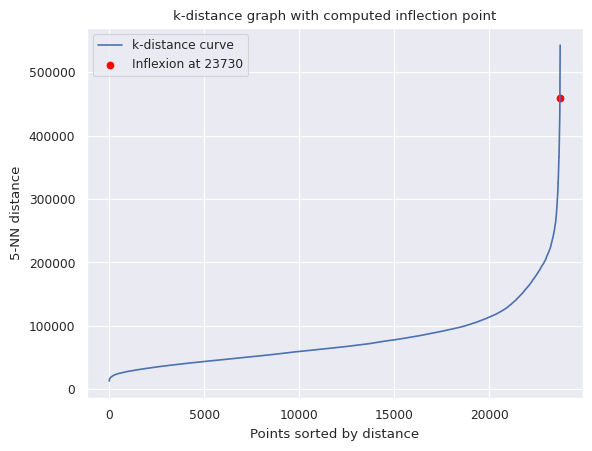

Selected epsilon based on inflection point: 458861.28125
Cluster 0:
Number of entries: 23738
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster -1:
Number of entries: 2
Metadata examples:
['4' 'AS']
['4' 'AS']


In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Flatten the data for distance calculation
all_subject_data_flat = all_subject_data.reshape(len(all_subject_data), -1)

# Fit Nearest Neighbors model
k = 5  # Typically, min_samples = 5
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(all_subject_data_flat)

# Compute the distances to the k-th nearest neighbor
distances, indices = neighbors.kneighbors(all_subject_data_flat)

# Sort the distances to plot the k-distance graph
distances = np.sort(distances[:, k-1])

# Calculate the first and second derivatives
first_derivative = np.gradient(distances)
second_derivative = np.gradient(first_derivative)

# Find the index of the maximum second derivative (the inflection point)
inflexion_idx = np.argmax(second_derivative)

# Plot the k-distance graph and mark the inflection point
plt.plot(distances, label='k-distance curve')
plt.scatter(inflexion_idx, distances[inflexion_idx], color='red', label=f'Inflexion at {inflexion_idx}')
plt.ylabel(f'{k}-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance graph with computed inflection point')
plt.legend()
plt.show()

# Apply DBSCAN with the identified epsilon (distance at the inflexion point)
eps_value = distances[inflexion_idx]
print(f"Selected epsilon based on inflection point: {eps_value}")

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps_value, min_samples=5, metric='euclidean')
cluster_labels = dbscan.fit_predict(all_subject_data_flat)

# Analyze the clustering results
clusters = {}
for i, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = {"data": [], "metadata": []}
    clusters[label]["data"].append(all_subject_data[i])
    clusters[label]["metadata"].append(all_metadata[i])

# Print clustering results with metadata
for cluster_id, cluster_info in clusters.items():
    print(f"Cluster {cluster_id}:")
    print(f"Number of entries: {len(cluster_info['data'])}")
    print("Metadata examples:")
    for meta in cluster_info["metadata"][:3]:  # Print first 3 metadata entries for each cluster
        print(meta)


In [8]:
# Dictionary to store clusters and metadata for each factor
results = {}

# Gradually decrease epsilon and observe cluster results
for factor in [0.5, .6,.75,.90,.99]:  # Try reducing eps by different factors
    eps_value = distances[inflexion_idx] * factor
    print(f"\nTrying DBSCAN with epsilon: {eps_value:.5f}")

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5, metric='euclidean')
    cluster_labels = dbscan.fit_predict(all_subject_data_flat)

    # Count the number of clusters and outliers
    unique_labels = set(cluster_labels)
    num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    num_noise = list(cluster_labels).count(-1)

    print(f"Number of clusters: {num_clusters}")
    print(f"Number of noise points: {num_noise}")

    # Save clusters and metadata for later plotting
    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = {"data": [], "metadata": []}
        clusters[label]["data"].append(all_subject_data[i])
        clusters[label]["metadata"].append(all_metadata[i])

    # Store results for this factor in the variable
    results[factor] = {"cluster_labels": cluster_labels, "metadata": all_metadata}

    # Optionally, print metadata of clusters
    for cluster_id, cluster_info in clusters.items():
        print(f"Cluster {cluster_id}:")
        print(f"Number of entries: {len(cluster_info['data'])}")
        print("Metadata examples:")
        for meta in cluster_info["metadata"][:3]:  # Print first 3 metadata entries for each cluster
            print(meta)



Trying DBSCAN with epsilon: 229430.64062
Number of clusters: 30
Number of noise points: 274
Cluster 0:
Number of entries: 22893
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster -1:
Number of entries: 274
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster 6:
Number of entries: 5
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster 1:
Number of entries: 19
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster 4:
Number of entries: 8
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster 2:
Number of entries: 8
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster 5:
Number of entries: 8
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster 3:
Number of entries: 9
Metadata examples:
['2' 'AS']
['2' 'AS']
['2' 'AS']
Cluster 12:
Number of entries: 5
Metadata examples:
['4' 'AS']
['4' 'AS']
['4' 'AS']
Cluster 7:
Number of entries: 7
Metadata examples:
['4' 'AS']
['4' 'AS']
['4' 'AS']
Cluster 13:
Number of entries: 18
Metadata examples:
['4' 

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Assuming all_subject_data_flat is your original flattened data
# Reduce dimensions using PCA for 2D plotting
pca = PCA(n_components=2)
subject_data_2d = pca.fit_transform(all_subject_data_flat)

# Create a colormap for plotting (different colors for different subjects)
cmap = ListedColormap(plt.cm.get_cmap('tab20').colors)

# Plot clusters for each factor
for factor, result in results.items():
    cluster_labels = result["cluster_labels"]
    metadata = result["metadata"]

    # Convert metadata into subject numbers (assuming metadata contains subject info in the first element)
    subject_numbers = np.array([int(meta[0]) for meta in metadata])  # Extract subject number from metadata

    # Plot clusters
    plt.figure(figsize=(10, 6))
    plt.title(f"DBSCAN Clusters for eps factor {factor}")

    # First, plot the individual points colored by subject number, with very small point size
    regular_points = subject_data_2d[cluster_labels != -1]
    noise_points = subject_data_2d[cluster_labels == -1]
    regular_subject_numbers = subject_numbers[cluster_labels != -1]
    noise_subject_numbers = subject_numbers[cluster_labels == -1]

    # Plot regular points (non-noise) as circles
    scatter = plt.scatter(regular_points[:, 0], regular_points[:, 1],
                          c=regular_subject_numbers, cmap=cmap, s=10, alpha=0.6, label="Subjects")

    # Plot noise points as X's but with the same subject colors
    plt.scatter(noise_points[:, 0], noise_points[:, 1],
                c=noise_subject_numbers, cmap=cmap, s=50, alpha=0.6, marker='x', label="Noise")

    # Then, overlay the cluster boundaries by plotting the convex hull of each cluster
    for label in np.unique(cluster_labels):
        if label != -1:  # Exclude noise
            # Extract the data points in the current cluster
            cluster_points = subject_data_2d[cluster_labels == label]

            if len(cluster_points) >= 3:  # Only process clusters with at least 3 points
                # Draw the convex hull or a boundary around the cluster points
                hull = ConvexHull(cluster_points)
                for simplex in hull.simplices:
                    plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', lw=1)  # Cluster boundary

    # Add colorbar to map subject numbers to colors
    plt.colorbar(scatter, label="Subject Number")

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean
from collections import defaultdict

# Assuming all_subject_data_flat is your original flattened data
# Reduce dimensions using PCA for 2D plotting
pca = PCA(n_components=2)
subject_data_2d = pca.fit_transform(all_subject_data_flat)

# Create a colormap for plotting (different colors for different subjects)
cmap = ListedColormap(plt.cm.get_cmap('tab20').colors)

# Dictionary to store cluster centroids and points
cluster_centroids = {}
subject_1_clusters = defaultdict(list)  # Stores subject 1 data points in each cluster

# Plot clusters for each factor (DBSCAN with different eps factors)
for factor, result in results.items():
    cluster_labels = result["cluster_labels"]
    metadata = result["metadata"]

    # Convert metadata into subject numbers (assuming metadata contains subject info in the first element)
    subject_numbers = np.array([int(meta[0]) for meta in metadata])  # Extract subject number from metadata

    # Plot clusters
    plt.figure(figsize=(10, 6))
    plt.title(f"DBSCAN Clusters for eps factor {factor}")

    # First, plot the individual points colored by subject number
    regular_points = subject_data_2d[cluster_labels != -1]
    noise_points = subject_data_2d[cluster_labels == -1]
    regular_subject_numbers = subject_numbers[cluster_labels != -1]
    noise_subject_numbers = subject_numbers[cluster_labels == -1]

    # Plot regular points (non-noise) as circles
    scatter = plt.scatter(regular_points[:, 0], regular_points[:, 1],
                          c=regular_subject_numbers, cmap=cmap, s=10, alpha=0.6, label="Subjects")

    # Plot noise points as X's but with the same subject colors
    plt.scatter(noise_points[:, 0], noise_points[:, 1],
                c=noise_subject_numbers, cmap=cmap, s=50, alpha=0.6, marker='x', label="Noise")

    # Overlay the cluster boundaries by plotting the convex hull of each cluster
    for label in np.unique(cluster_labels):
        if label != -1:  # Exclude noise
            # Extract the data points in the current cluster
            cluster_points = subject_data_2d[cluster_labels == label]
            cluster_subjects = subject_numbers[cluster_labels == label]

            # Compute the centroid of the cluster and store it
            cluster_centroid = np.mean(cluster_points, axis=0)
            cluster_centroids[label] = cluster_centroid

            # If subject 1 is in this cluster, store its points
            if 1 in cluster_subjects:
                subject_1_clusters[label].append(cluster_points[cluster_subjects == 1])

            if len(cluster_points) >= 3:  # Only process clusters with at least 3 points
                # Draw the convex hull or a boundary around the cluster points
                hull = ConvexHull(cluster_points)
                for simplex in hull.simplices:
                    plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', lw=1)  # Cluster boundary

    # Add colorbar to map subject numbers to colors
    plt.colorbar(scatter, label="Subject Number")

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Calculate the distances from subject 1's clusters to other clusters
print(f"Distances from subject 1's clusters to other clusters (factor = {factor}):")
subject_1_combined_centroid = None

# Iterate over clusters containing subject 1
if subject_1_clusters:
    for label, subject_1_points in subject_1_clusters.items():
        subject_1_points = np.vstack(subject_1_points)  # Combine points from this cluster for subject 1
        subject_1_cluster_centroid = np.mean(subject_1_points, axis=0)  # Compute centroid for this cluster

        print(f"Cluster {label} containing subject 1:")
        for other_label, other_centroid in cluster_centroids.items():
            if label != other_label:  # Skip the current cluster
                dist = euclidean(subject_1_cluster_centroid, other_centroid)
                print(f"  Distance to cluster {other_label}: {dist:.2f}")

        # Optional: Combine subject 1 centroids to get an overall centroid
        if subject_1_combined_centroid is None:
            subject_1_combined_centroid = subject_1_cluster_centroid
        else:
            # Weighted combination of centroids
            subject_1_combined_centroid = (subject_1_combined_centroid + subject_1_cluster_centroid) / 2
else:
    print("No clusters contain subject 1.")

if subject_1_combined_centroid is not None:
    print("\nDistance from combined subject 1 centroid to other clusters:")
    for other_label, other_centroid in cluster_centroids.items():
        dist = euclidean(subject_1_combined_centroid, other_centroid)
        print(f"  Distance to cluster {other_label}: {dist:.2f}")


Output hidden; open in https://colab.research.google.com to view.